In [1]:
%load_ext tensorboard

!rm -rf ./data/logs/

In [2]:
import json
import os
import numpy as np
import tensorflow as tf
import mpnn
from typing import Dict

tf.keras.backend.clear_session()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/fit")

In [3]:
data_fn = "data/qm9/dataset_100.json"
with open(data_fn, "r") as fp:
    dataset = json.load(fp)
graph = dataset[0]
element = [list(node.values())[4] for node in graph["node_list"].values()]
data_fn = "data/qm9/dataset_100.json"
with open(data_fn, "r") as fp:
    dataset = json.load(fp)

num_node_features = tf.convert_to_tensor(
    [list(node.values()) for node in dataset[0]["node_list"].values()]
).shape[1]
num_edge_features = tf.convert_to_tensor(
    [list(dataset[0]["edge_list"][key].values()) for key in sorted(dataset[0]["edge_list"].keys())]
).shape[1]
dataShape = mpnn.GraphInputShapes(
    node_features=tf.TensorShape((None, num_node_features)),
    edge_features=tf.TensorShape((None, num_edge_features))
)
    
def get_data(dataset):
    for graph in dataset:
        data = mpnn.GraphInput(
            node_features=tf.convert_to_tensor([list(node.values()) for node in graph["node_list"].values()]),
            edge_features=tf.convert_to_tensor(
                [list(graph["edge_list"][key].values()) for key in sorted(graph["edge_list"].keys())]
            ),
            adjacency_lists=tuple([tf.convert_to_tensor(adj) for adj in graph["adjacency"].values()]),
            edge_to_idx={key: sorted(graph["edge_list"].keys()).index(key) for key in graph["edge_list"]}
        )
        target = tf.constant([graph["molecule_props"]["dipole_moment"]])
        yield data, target

dataShape

GraphInputShapes(node_features=TensorShape([None, 11]), edge_features=TensorShape([None, 5]))

In [4]:
model = mpnn.MessagePassingNet()
model.compile(
    optimizer="adam",
    loss="mse"
)
model.build(dataShape)

In [5]:
n_epochs = 10
loss = []
for i in range(n_epochs):
    for j, (data, y) in enumerate(get_data(dataset)):
        info = model.train_step((data, y))
        loss.append(info["loss"].numpy())    
    print(f"Epoch {i}: {info['loss'].numpy()}")

Epoch 0: 10.836947441101074
Epoch 1: 9.599767684936523
Epoch 2: 8.629627227783203
Epoch 3: 7.903057098388672
Epoch 4: 7.342144012451172
Epoch 5: 6.8970184326171875
Epoch 6: 6.536951541900635
Epoch 7: 6.238076686859131
Epoch 8: 5.97803258895874
Epoch 9: 5.732377529144287


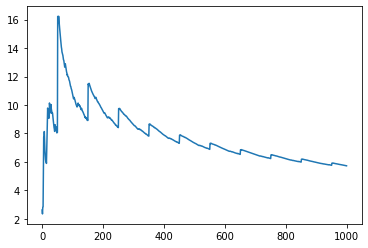

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Create data
y = loss
x = [i for i in range(n_epochs*len(dataset))]
# Plot
plt.plot(x, y )
plt.show()